# ITPR1
Pathogenic variation in the ITPR1 gene is associated with

[Gillespie syndrome (GLSP)](https://omim.org/entry/206700), 
[spinocerebellar ataxia-15 (SCA15)](https://omim.org/entry/606658), and
[spinocerebellar ataxia-29 (SCA29)](https://omim.org/entry/117360).

Pathological variants associated with SCA29 have been shown to fall into several mechanistic classes.

- R241K, T267M, T267R, R269G, R269W, S277I, K279E, A280D, E497K: Impair IP3 binding to ITPR1 ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- In contrast, V479I, T579I, and N587D did not affect IP3 binding ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- Disrupt ITPR1 channel activity without impairing IP3 binding: T579I, N587D ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- Two pathological variants, S1478D and V1538M, are located within the CA8 binding site. V1538M completely abolished CA8 binding. Both variants abolish CA8-mediated suppression of ITPR1 activity ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/)). V1538M was identified in an individual with SCA29 and S1478D was found in an individual with ataxic cerebral palsy.


    We will follow [Tolonen et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/37964426/) and divide the sequence encoded by NM_001378452.1 (9908nt; 2758 aa) into 
    - Suppresor domain (1-223)
    - IP3 binding: 226-578
    - Regulatory/Coupling: 605-2217
    - Channel: 2227-2758 


In [1]:
import gpsea
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = "ITPR1"	

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
print(f"{len(phenopackets)} phenopackets imported for {cohort_name}")
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

170 phenopackets imported for ITPR1
Individuals Processed: 100%|██████████| 170/170 [00:22<00:00,  7.65individuals/s]
Loaded 170 individuals
Validated under permissive policy
No errors or warnings were found


We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for *ITPR1*.

In [5]:
ITPR1_MANE_transcript = 'NM_001378452.1'
ITPR1_protein_id = 'NP_001365381.1' # Homo sapiens inositol 1,4,5-trisphosphate receptor type 1 (ITPR1), transcript variant 4, mRNA

In [6]:
from gpsea.view import CohortViewable
cv = CohortViewable(hpo=hpo)
cv.process(cohort=cohort, transcript_id=ITPR1_MANE_transcript)

HPO Term,ID,Seen in n individuals
Ataxia,HP:0001251,83
Hypotonia,HP:0001252,75
Nystagmus,HP:0000639,57
Delayed ability to sit,HP:0025336,56
Dysarthria,HP:0001260,54
Delayed ability to walk,HP:0031936,54
Delayed speech and language development,HP:0000750,53
Global developmental delay,HP:0001263,49
Cerebellar atrophy,HP:0001272,47
Dysmetria,HP:0001310,32


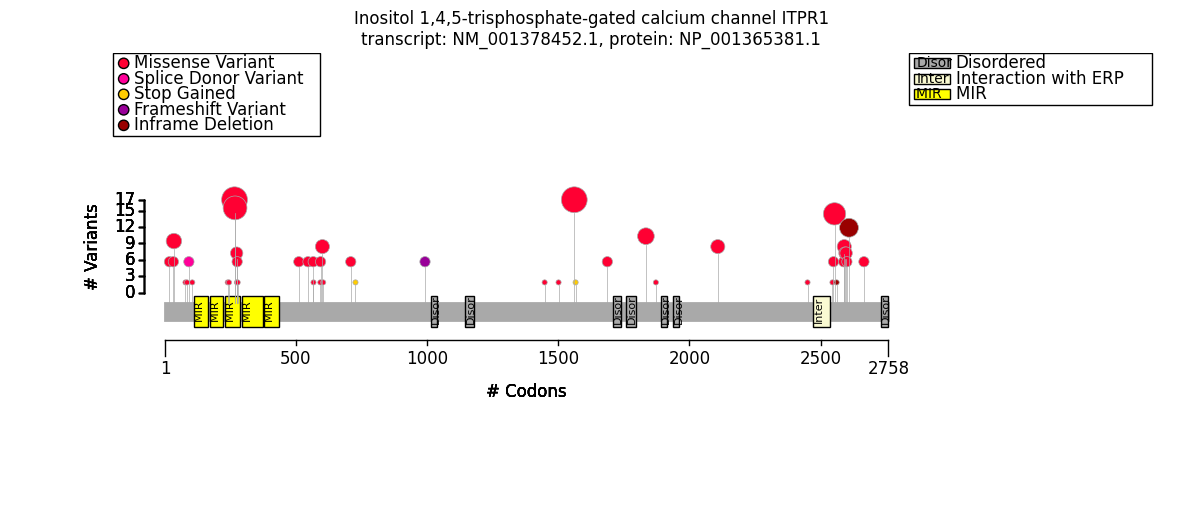

In [10]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(ITPR1_MANE_transcript)
protein_meta = pms.annotate(ITPR1_protein_id)
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer
pms = UniprotProteinMetadataService()
protein_meta = pms.annotate(ITPR1_protein_id)
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(ITPR1_MANE_transcript)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.savefig('ikzf1_protein_diagram.pdf')  #

In [12]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=ITPR1_MANE_transcript)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Effects,Count
SO:1000029_HGNC:6180_ITPR1,SV involving ITPR1,p.?,chromosomal deletion,19
3_4706193_4706193_G_A,c.4684G>A,p.Val1562Met,missense,17
3_4645673_4645673_C_T,c.800C>T,p.Thr267Met,missense,14
3_4645678_4645678_C_T,c.805C>T,p.Arg269Trp,missense,14
3_4814521_4814521_G_A,c.7660G>A,p.Gly2554Arg,missense,10
3_4815176_4815179_CAGA_C,c.7831_7833del,p.Lys2611del,inframe deletion,8
3_4735314_4735314_T_C,c.5504T>C,p.Leu1835Pro,missense,6
3_4521037_4521037_C_T,c.106C>T,p.Arg36Cys,missense,5
3_4667467_4667467_A_G,c.1804A>G,p.Asn602Asp,missense,4
3_4815132_4815132_T_C,c.7781T>C,p.Phe2594Ser,missense,3


# Hypothesis

  We will follow [Tolonen et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/37964426/) and divide the sequence encoded by NM_001378452.1 (9908nt; 2758 aa) into 
  
  - Suppresor domain (1-223)
  - IP3 binding: 226-578
  - Regulatory/Coupling: 605-2217
  - Channel: 2227-2758 

The authors state: The distribution of variants across different domains of the IP3R1 protein suggests both loss-of-function (LOF) and gain-of-function (GOF) disease mechanisms (Fig. 2) with important implications for therapeutic development. The majority of SCA29 and GLSP cases harbor variants in the IP3-binding and channel domains.

N-Terminal variants are solely associated with SCA29, while C-terminal variants can cause either GLSP (p.Gly2554Arg and p.Lys2611del) or SCA29.

We will also test structural variants against missense variants for association with SCA15.

In [13]:
from gpsea.analysis.predicate.genotype import VariantPredicates
from gpsea.model.genome import Region
ip3_region_pred = VariantPredicates.region(region=Region(start=225, end=578), tx_id=ITPR1_MANE_transcript)

In [14]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import  groups_predicate, VariantPredicates

vp = VariantPredicates.variant_key("3_4645673_4645673_C_T") | VariantPredicates.variant_key("3_4645678_4645678_C_T")



# The following variants are at or very near IP3 binding pocket
variant_keys = ('3_4645673_4645673_C_T',  ## p.Thr267Met	
                '3_4645673_4645673_C_G', #p.Thr267Arg
                '3_4645678_4645678_C_T', #	p.Arg269Trp'
                '3_4665283_4665283_A_G',#	p.Tyr567Cys
                '3_4663186_4663186_G_A', #	p.Glu512Lys	missense
                '3_4665285_4665285_A_G',#	p.Arg568Gly	missense
                )
compound = VariantPredicates.any(VariantPredicates.variant_key(key) for key in variant_keys)

ip3_predicate = groups_predicate(
    predicates=(
        ip3_region_pred,
        ~ip3_region_pred,
    ),
    group_names=('IP3 binding', 'Others'),
)
ip3_predicate.display_question()

'Genotype group: IP3 binding, Others'

In [16]:
from gpsea.analysis.predicate.genotype import autosomal_dominant

gt_predicate = autosomal_dominant(
    variant_predicate=ip3_predicate,
)

AssertionError: 

In [18]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.5)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()

from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=ip3_predicate,
    pheno_predicates=pheno_predicates,
)

In [19]:
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.5,42
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF03,Skipping term because of a child term with the same individual counts,2
HMF04,Skipping term because all genotypes have same HPO observed proportions,35
HMF05,Skipping term because one genotype had zero observations,8
HMF06,Skipping term with less than 7 observations (not powered for 2x2),115
HMF08,Skipping general term,59


In [20]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

Genotype group                                     IP3 binding          \
                                                         Count Percent   
Nystagmus [HP:0000639]                                   36/38     95%   
Neurodevelopmental delay [HP:0012758]                    35/35    100%   
Horizontal nystagmus [HP:0000666]                          6/8     75%   
Oculomotor apraxia [HP:0000657]                          15/22     68%   
Hypoplasia of the iris [HP:0007676]                        0/5      0%   
Slow saccadic eye movements [HP:0000514]                   4/5     80%   
Delayed speech and language development [HP:000...       16/17     94%   
Spasticity [HP:0001257]                                    3/3    100%   
Appendicular spasticity [HP:0034353]                       2/2    100%   
Strabismus [HP:0000486]                                  13/16     81%   
Intellectual disability, borderline [HP:0006889]          1/10     10%   
Global developmental delay [HP:0001263]                  17/20     85%   
Microcephaly [HP:0000252]                                  3/4     75%   
Lower limb spasticity [HP:0002061]                         2/3     67%   
Intention tremor [HP:0002080]                              2/6     33%   
Abnormality of extrapyramidal motor function [H...         0/7      0%   
Slowed horizontal saccades [HP:0007885]                    2/3     67%   
Myokymia [HP:0002411]                                      3/3    100%   
Motor delay [HP:0001270]                                 30/33     91%   
Gaze-evoked nystagmus [HP:0000640]                         6/9     67%   
Esodeviation [HP:0020045]                                  3/6     50%   
Delayed ability to walk with support [HP:0033257]          4/7     57%   
Delayed ability to walk [HP:0031936]                     17/20     85%   
Delayed gross motor development [HP:0002194]             24/27     89%   
Kinetic tremor [HP:0030186]                                2/5     40%   
Delayed ability to sit [HP:0025336]                      16/19     84%   
Cerebellar cortical atrophy [HP:0008278]                   0/2      0%   
Hypertonia [HP:0001276]                                    4/4    100%   
Hypotonia [HP:0001252]                                   38/39     97%   
Generalized hypotonia [HP:0001290]                         6/7     86%   
Truncal titubation [HP:0030147]                            0/3      0%   
Tremor by anatomical site [HP:0030188]                     0/3      0%   
Intellectual disability [HP:0001249]                     20/27     74%   
Dysdiadochokinesis [HP:0002075]                            1/1    100%   
Limb ataxia [HP:0002070]                                   3/3    100%   
Gait ataxia [HP:0002066]                                   5/5    100%   
Ataxia [HP:0001251]                                      47/47    100%   
Postural tremor [HP:0002174]                              8/13     62%   
Limb dysmetria [HP:0002406]                                2/6     33%   
Cerebellar hypoplasia [HP:0001321]                         2/3     67%   
Hypermetropia [HP:0000540]                                 2/2    100%   
Dysmetria [HP:0001310]                                   11/15     73%   
Cerebral atrophy [HP:0002059]                              1/4     25%   
Ptosis [HP:0000508]                                        4/4    100%   
Abnormal saccadic eye movements [HP:0000570]               4/4    100%   
Truncal ataxia [HP:0002078]                                2/2    100%   
Intellectual disability, mild [HP:0001256]                7/17     41%   
Poor head control [HP:0002421]                             3/5     60%   
Cerebellar vermis atrophy [HP:0006855]                     5/7     71%   
Cerebellar atrophy [HP:0001272]                          26/28     93%   
Hyperreflexia [HP:0001347]                                 3/6     50%   
Action tremor [HP:0002345]                               12/15     80%   
Dysa

# Structural variants
todo describe

In [25]:
from gpsea.model import VariantEffect

from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant


sv_deletion = VariantPredicates.structural_type('SO:1000029') 
gt_predicate = autosomal_dominant(sv_deletion)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

What is the genotype group                          HOM_REF            HET  \
                                                      Count Percent  Count   
Neurodevelopmental delay [HP:0012758]               105/106     99%   0/19   
Motor delay [HP:0001270]                              90/97     93%   0/19   
Delayed gross motor development [HP:0002194]          78/85     92%   0/19   
Delayed speech and language development [HP:000...    53/60     88%   0/19   
Delayed ability to walk [HP:0031936]                  54/62     87%   0/19   
Delayed ability to sit [HP:0025336]                   56/65     86%   0/19   
Global developmental delay [HP:0001263]               49/58     84%   0/19   
Delayed ability to walk with support [HP:0033257]      9/16     56%   0/19   
Abnormal pyramidal sign [HP:0007256]                   1/19      5%    4/4   
Limb dysmetria [HP:0002406]                            7/19     37%    9/9   
Gaze-evoked nystagmus [HP:0000640]                    10/41     24%    7/9   
Nystagmus [HP:0000639]                                68/97     70%  17/17   
Cerebellar vermis atrophy [HP:0006855]                16/24     67%  15/15   
Intention tremor [HP:0002080]                         22/34     65%    9/9   
Hypometric saccades [HP:0000571]                        0/3      0%    7/9   
Hypermetric saccades [HP:0007338]                       0/3      0%    7/9   
Myokymia [HP:0002411]                                   3/3    100%    2/9   
Cerebellar cortical atrophy [HP:0008278]                2/7     29%  11/14   
Gait ataxia [HP:0002066]                              16/24     67%  10/10   
Abnormal saccadic eye movements [HP:0000570]            4/7     57%    8/8   
Kinetic tremor [HP:0030186]                           22/32     69%    9/9   
Limb ataxia [HP:0002070]                              10/21     48%    7/8   
Dysphagia [HP:0002015]                                 2/12     17%   9/18   
Dysmetria [HP:0001310]                                39/51     76%    9/9   
Action tremor [HP:0002345]                            46/56     82%  11/11   
Truncal ataxia [HP:0002078]                           12/16     75%    4/9   
Spasticity [HP:0001257]                                 3/6     50%    1/9   
Tremor [HP:0001337]                                   66/76     87%  11/11   
Cerebellar atrophy [HP:0001272]                       66/71     93%  15/15   
Hyperreflexia [HP:0001347]                            12/19     63%   5/10   
Ataxia [HP:0001251]                                 137/141     97%  19/19   
Dysarthria [HP:0001260]                               39/49     80%  15/19   
Cognitive impairment [HP:0100543]                       4/5     80%    2/2   
Hypertonia [HP:0001276]                                 4/7     57%    1/1   
Postural tremor [HP:0002174]                          17/36     47%   9/18   

What is the genotype group                                                     \
                                                   Percent Corrected p values   
Neurodevelopmental delay [HP:0012758]                   0%       5.184510e-20   
Motor delay [HP:0001270]                                0%       3.969823e-15   
Delayed gross motor development [HP:0002194]            0%       2.553539e-14   
Delayed speech and language development [HP:000...      0%       6.512289e-12   
Delayed ability to walk [HP:0031936]                    0%       1.026228e-11   
Delayed ability to sit [HP:0025336]                     0%       1.219666e-11   
Global developmental delay [HP:0001263]                 0%       6.801479e-11   
Delayed ability to walk with support [HP:0033257]       0%       7.088486e-04   
Abnormal pyramidal sign [HP:0007256]                  100%       2.195872e-03   
Limb dysmetria [HP:0002406]                           100%       9.921962e-03   
Gaze-evoked nystagmus [HP:0000640]                     78%       1.409039e-02   
Nystagmus [HP:0000639]                                100%  

In [22]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Sex of the individual                              FEMALE           MALE  \
                                                    Count Percent  Count   
Myoclonus [HP:0001336]                                4/6     67%    0/4   
Hypoplasia of the iris [HP:0007676]                 15/21     71%   5/13   
Poor head control [HP:0002421]                       9/10     90%    3/7   
Strabismus [HP:0000486]                               5/5    100%    5/8   
Generalized hypotonia [HP:0001290]                  11/11    100%    3/4   
Delayed speech and language development [HP:000...  14/20     70%   6/13   
Abnormality of extrapyramidal motor function [H...   3/12     25%    4/8   
Limb ataxia [HP:0002070]                            11/18     61%    6/7   
Hypotonia [HP:0001252]                              38/38    100%  21/22   
Dysarthria [HP:0001260]                             27/32     84%  19/20   
Cognitive impairment [HP:0100543]                     2/3     67%    4/4   
Intellectual disability, borderline [HP:0006889]     9/17     53%    3/9   
Global developmental delay [HP:0001263]             18/26     69%  11/19   
Cerebellar cortical atrophy [HP:0008278]              3/6     50%    1/4   
Head tremor [HP:0002346]                              4/9     44%    4/6   
Oculomotor apraxia [HP:0000657]                      5/14     36%   6/12   
Intellectual disability [HP:0001249]                34/41     83%  23/26   
Postural tremor [HP:0002174]                        11/24     46%   8/14   
Delayed ability to walk [HP:0031936]                13/24     54%   8/13   
Intellectual disability, mild [HP:0001256]          14/28     50%   8/19   
Nystagmus [HP:0000639]                              34/46     74%  19/27   
Cerebellar atrophy [HP:0001272]                     41/43     95%  27/28   
Neurodevelopmental delay [HP:0012758]               40/46     87%  23/27   
Cerebral atrophy [HP:0002059]                         1/3     33%    2/4   
Gait ataxia [HP:0002066]                            17/20     85%   9/10   
Delayed gross motor development [HP:0002194]        28/39     72%  13/18   
Motor delay [HP:0001270]                            35/46     76%  17/22   
Cerebellar vermis atrophy [HP:0006855]              15/19     79%    7/9   
Dysmetria [HP:0001310]                              10/12     83%  10/11   
Delayed ability to sit [HP:0025336]                 17/28     61%   9/14   
Hyperreflexia [HP:0001347]                          10/17     59%   7/12   
Intention tremor [HP:0002080]                         4/6     67%    5/7   
Kinetic tremor [HP:0030186]                           4/6     67%    5/6   
Action tremor [HP:0002345]                          18/20     90%  15/16   
Tremor [HP:0001337]                                 23/25     92%  19/20   
Truncal titubation [HP:0030147]                       4/6     67%    4/5   
Limb dysmetria [HP:0002406]                           6/8     75%    1/2   
Hypertonia [HP:0001276]                               2/4     50%    2/3   
Truncal ataxia [HP:0002078]                          8/11     73%   8/10   
Tremor by anatomical site [HP:0030188]                4/6     67%    4/5   
Ptosis [HP:0000508]                                   4/6     67%    2/2   
Cerebellar vermis hypoplasia [HP:0001320]             2/4     50%    2/3   

Sex of the individual                                                          \
                                                   Percent Corrected p values   
Myoclonus [HP:0001336]                                  0%                1.0   
Hypoplasia of the iris [HP:0007676]                    38%                1.0   
Poor head control [HP:0002421]                         43%                1.0   
Strabismus [HP:0000486]                                62%                1.0   
Generalized hypotonia [HP:0001290]                     75%                1.0   
Delayed speech and language development [HP:000...     46%                1.0   
Abnorma